- Take the RNA-seq data for Huh7 and PLC
- map them to Recon3D genes 
- note any missing genes
- explore the data for metabolic genes
- Assign max. score for missing genes
- Fill zeros with microarray data
- export the data

# Setup

In [1]:
import pandas as pd
import numpy as np
import cobra
import pickle
import matplotlib.pyplot as plt

import mygene
mg = mygene.MyGeneInfo()

plt.rc('font', size=20)

# Read the transcriptomics

In [2]:
huh7 = pd.read_csv('../Data/GSM2306677_Huh7_NTC.txt', sep='\t', index_col=0)
plc = pd.read_csv('../Data/GSM2306679_PLC_NTC.txt', sep='\t', index_col=0)

df_data = huh7.copy()
df_data['PLC_NTC TPM'] = plc

df_data.columns = ['Huh7','PLC']

print('Imported dataframe size:',len(df_data))
df_data.head()

Imported dataframe size: 25343


,Huh7,PLC
gene_id,,
A1BG,17.05,6.45
A1BG-AS1,0.00,3.21
A1CF,116.36,30.41
A2M,1589.44,1267.99
A2M-AS1,0.35,0.65


# Get the list of metabolic genes from Recon3D

In [3]:
# make a second dataframe for metabolic genes only
with open('../Models/Recon3DModel_301_simple_medium','rb') as f:
    model = pickle.load(f)

l_genes_full = [g.id for g in model.genes]
l_genes = [g.id.split('.')[0] for g in model.genes]

# Set up the dataframe

In [4]:
df = pd.DataFrame(index=l_genes,columns=['Huh7','PLC','Symbol','Alias','Name'])

# Query from entrezgene to gene symbols, alias and name
This query yields 3 genes that are not found: 0 does not exist, the other two missing genes have been withdrawn from NCBI.

The warning about duplicates is due to the fact that the input entrez gene list contains duplicates.

In [5]:
out = mg.querymany(l_genes, scopes='entrezgene', fields='symbol,alias,name', species='human')

df = pd.DataFrame(out)[['query','symbol','alias','name']]
df.columns = ['Entrez','Symbol','Alias','Name']
df = df.set_index('Entrez')

df['Huh7'] = np.nan
df['PLC'] = np.nan

# reset index to full gene IDs
df.index = l_genes_full

df.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2248...done.
Finished.
237 input query terms found dup hits:
	[('314', 2), ('6818', 3), ('3948', 2), ('57835', 4), ('4967', 2), ('1312', 2), ('18', 2), ('51166', 
3 input query terms found no hit:
	['100507855', '8041', '0']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,Symbol,Alias,Name,Huh7,PLC
8639.1,AOC3,"[HPAO, SSAO, VAP-1, VAP1]",amine oxidase copper containing 3,NaN,NaN
314.2,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,NaN,NaN
26.1,AOC1,"[ABP, ABP1, DAO, DAO1, KAO]",amine oxidase copper containing 1,NaN,NaN
314.1,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,NaN,NaN
1591.1,CYP24A1,"[CP24, CYP24, HCAI, HCINF1, P450-CC24]",cytochrome P450 family 24 subfamily A member 1,NaN,NaN


# Match the symbol column to the dataset and save the TPM scores

In [6]:
count = 0
for indx,row in df.iterrows():
    s = df.at[indx,'Symbol']
    
    if s in df_data.index:
        v = df_data.loc[s,['Huh7','PLC']]
        df.at[indx,['Huh7','PLC']] = v
    else:
        count += 1

print('Could not find', count, 'gene symbols in the dataset')
df.head()

Could not find 105 gene symbols in the dataset


,Symbol,Alias,Name,Huh7,PLC
8639.1,AOC3,"[HPAO, SSAO, VAP-1, VAP1]",amine oxidase copper containing 3,1.35,0.66
314.2,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,2.64,2.02
26.1,AOC1,"[ABP, ABP1, DAO, DAO1, KAO]",amine oxidase copper containing 1,0.09,0.15
314.1,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,2.64,2.02
1591.1,CYP24A1,"[CP24, CYP24, HCAI, HCINF1, P450-CC24]",cytochrome P450 family 24 subfamily A member 1,0.26,72.29


In [7]:
missing = df[df['Huh7'].isnull() | df['PLC'].isnull()].index.tolist()

for indx in missing:
    aliases = df.at[indx,'Alias']
    
    if type(aliases) == float:
        continue
    
    for alias in aliases:
        if alias in df_data.index:
            v = df_data.loc[alias,['Huh7','PLC']]
            df.at[indx,['Huh7','PLC']] = v
            break
            
missing = df[df['Huh7'].isnull() | df['PLC'].isnull()].index.tolist()
print('After alias searching we are left with', len(missing),'remaining missing genes.')

df.loc[missing][['Symbol','Alias','Name']].to_excel('../Tables/Unmappable_RNA-seq_genes.xlsx')

df.loc[missing][['Symbol','Alias','Name']]

After alias searching we are left with 16 remaining missing genes.


,Symbol,Alias,Name
201288.1,NOS2P2,NOS2B,nitric oxide synthase 2 pseudogene 2
645740.1,NOS2P1,NOS2C,nitric oxide synthase 2 pseudogene 1
728441.1,GGT2,"[GGT, GGT 2]",gamma-glutamyltransferase 2
102724560.1,CBSL,CBS,cystathionine-beta-synthase like
65263.1,PYCR3,PYCRL,pyrroline-5-carboxylate reductase 3
8781.1,PSPHP1,"[CO9, PSPHL]",phosphoserine phosphatase pseudogene 1
100507855.1,NaN,NaN,NaN
644378.1,GCNT2P1,"[GCNT2P, GCNT6]",GCNT2 pseudogene 1
284004.1,HEXD,HEXDC,hexosaminidase D
8041.1,NaN,NaN,NaN


# Calculate the fold-change from Huh7 to PLC

In [8]:
# calculate Fold_change and remove zeros and infinities
df['Fold_change'] = df['PLC'] / df['Huh7']
df[df['Fold_change'] > 1e7]['Fold_change'] = 999999 # to avoid infinity from X/0
df.head()

/Users/thierry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Symbol,Alias,Name,Huh7,PLC,Fold_change
8639.1,AOC3,"[HPAO, SSAO, VAP-1, VAP1]",amine oxidase copper containing 3,1.35,0.66,0.488889
314.2,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,2.64,2.02,0.765152
26.1,AOC1,"[ABP, ABP1, DAO, DAO1, KAO]",amine oxidase copper containing 1,0.09,0.15,1.666667
314.1,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,2.64,2.02,0.765152
1591.1,CYP24A1,"[CP24, CYP24, HCAI, HCINF1, P450-CC24]",cytochrome P450 family 24 subfamily A member 1,0.26,72.29,278.038462


# Looking at the mean and median expression levels of the genome-wide vs. metabolic genes

In [9]:
print(df.PLC.mean(), df.Huh7.mean())
print(df_data.PLC.mean(), df_data.Huh7.mean())

81.87548387096778 81.72271057347655
39.45861263465316 39.45864301779612


In [10]:
print(df.PLC.median(), df.Huh7.median())
print(df_data.PLC.median(), df_data.Huh7.median())

15.64 15.98
0.97 1.28


# Analyzing statistics of the metabolic genes in detail

/Users/thierry/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824 RuntimeWarning: invalid value encountered in greater_equal
/Users/thierry/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825 RuntimeWarning: invalid value encountered in less_equal


Number of genes with zero TPM in both cell lines: 186
Number of genes with TPMs below the median in both cell lines: 215
Number of genes expressed above the median in both cell lines: 1422
Number of genes expressed above the mean in both cell lines: 623
Number of expressed genes with a >3x fold-change: 415


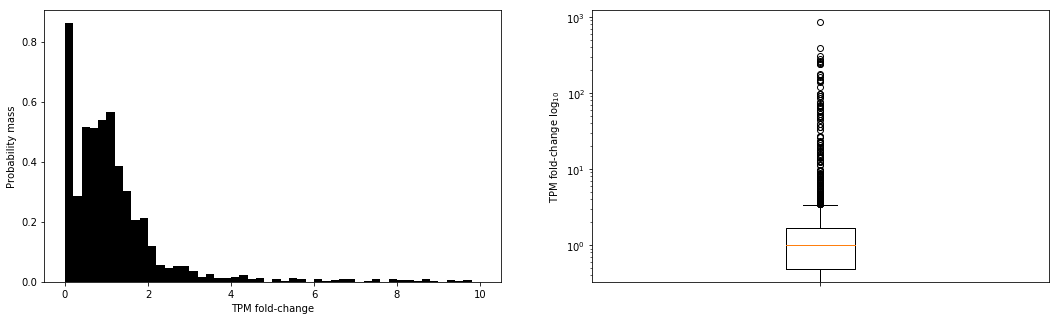

In [11]:
# find common non-expressed genes
df_zeros = df[(df['Huh7']==0) & (df['PLC']==0)]
print('Number of genes with zero TPM in both cell lines:',len(df_zeros))

# find common low expression genes (below median)
t = df_data[['Huh7','PLC']].quantile(0.5).values
df_low = df[(df['Huh7']>0) & (df['PLC']>0)]
df_low = df_low[(df_low['Huh7']<t[0]) & (df_low['PLC']<t[1])]
print('Number of genes with TPMs below the median in both cell lines:',len(df_low))

# find all common (somewhat) expressed metabolic genes
df_expr = df[(df['Huh7']>=t[0]) & (df['PLC']>=t[1])]
print('Number of genes expressed above the median in both cell lines:',len(df_expr))

# find all common highly expressed metabolic genes
t = df_data[['Huh7','PLC']].mean().values
df_high = df[(df['Huh7']>=t[0]) & (df['PLC']>=t[1])]
print('Number of genes expressed above the mean in both cell lines:',len(df_high))

# find all genes that are expressed (> median) in at least 1 cell line and have a substantial fold-change
t = df_data[['Huh7','PLC']].quantile(0.5).values
df_expr = df[(df['Huh7']>=t[0]) | (df['PLC']>=t[1])]
df_expr_fc = df_expr[(df_expr['Fold_change']>3) | (df_expr['Fold_change']<0.333)]
print('Number of expressed genes with a >3x fold-change:',len(df_expr_fc))

fig, (ax1,ax2)= plt.subplots(1, 2)
fig.set_size_inches(18,5)

ax1.hist(df['Fold_change'].values,bins=50, normed=True, range=(0,10),color='k') 
ax1.set_xlabel('TPM fold-change')
ax1.set_ylabel('Probability mass')

bp = ax2.boxplot(df[~df['Fold_change'].isna()]['Fold_change'].values)
ax2.set_xticklabels('')
ax2.set_yscale('log')
ax2.set_ylabel(r'TPM fold-change $\log_{10}$')

fig.savefig('../Figures/RNA_seq_fold_change_PMF.png',bbox_inches = 'tight')
plt.show()

# assign the maximum score to the missing genes

In [12]:
df.loc[missing,['Huh7','PLC']] = df[['Huh7','PLC']].max().values

df.loc[missing]

,Symbol,Alias,Name,Huh7,PLC,Fold_change
201288.1,NOS2P2,NOS2B,nitric oxide synthase 2 pseudogene 2,13833.95,16175.98,NaN
645740.1,NOS2P1,NOS2C,nitric oxide synthase 2 pseudogene 1,13833.95,16175.98,NaN
728441.1,GGT2,"[GGT, GGT 2]",gamma-glutamyltransferase 2,13833.95,16175.98,NaN
102724560.1,CBSL,CBS,cystathionine-beta-synthase like,13833.95,16175.98,NaN
65263.1,PYCR3,PYCRL,pyrroline-5-carboxylate reductase 3,13833.95,16175.98,NaN
8781.1,PSPHP1,"[CO9, PSPHL]",phosphoserine phosphatase pseudogene 1,13833.95,16175.98,NaN
100507855.1,NaN,NaN,NaN,13833.95,16175.98,NaN
644378.1,GCNT2P1,"[GCNT2P, GCNT6]",GCNT2 pseudogene 1,13833.95,16175.98,NaN
284004.1,HEXD,HEXDC,hexosaminidase D,13833.95,16175.98,NaN
8041.1,NaN,NaN,NaN,13833.95,16175.98,NaN


# Double check zeros against the microarray dataset
- If RNA-seq zeros are zero in microarray as well: keep them at zero
- If they are non-zero: calculate the proportion vs. the median in microarray and scale that same portion to the RNA-seq

In [13]:
df_array = pd.read_csv('../Data/microarray_data_with_entrez_genes.csv', sep='\t',index_col='gene')
df_array.index = df_array.index.astype(str)
df_array.head()

,Symbol,Alias,Name,Huh7,PLC,Fold_change
gene,,,,,,
8639.1,AOC3,"['HPAO', 'SSAO', 'VAP-1', 'VAP1']",amine oxidase copper containing 3,33.605,45.87,1.364975
314.2,AOC2,"['DAO2', 'RAO', 'SSAO']",amine oxidase copper containing 2,56.975,42.32,0.742782
26.1,AOC1,"['ABP', 'ABP1', 'DAO', 'DAO1', 'KAO']",amine oxidase copper containing 1,26.660,24.28,0.910728
314.1,AOC2,"['DAO2', 'RAO', 'SSAO']",amine oxidase copper containing 2,56.975,42.32,0.742782
1591.1,CYP24A1,"['CP24', 'CYP24', 'HCAI', 'HCINF1', 'P450-CC24']",cytochrome P450 family 24 subfamily A member 1,12.975,614.13,47.331792


Find the genes with 0 expression

In [14]:
huh7_zeros = list(set(df[df.Huh7 == 0].index))
PLC_zeros = list(set(df[df.PLC == 0].index))
len(huh7_zeros),len(PLC_zeros)

(262, 310)

Compare with microarray and update scores if it's non-zero there

In [15]:
for g in huh7_zeros:
    row = df_array.loc[g]
    
    if isinstance(row,pd.DataFrame):
        v = row.iloc[0].Huh7
    else:
        v = row.Huh7
    
    if v > 0:
        proportion = v / df_array.Huh7.median()
        
        df.at[g,'Huh7'] = proportion * df_data.Huh7.median() # note that the median is calculated genome-wide
        
for g in PLC_zeros:
    row = df_array.loc[g]
    
    if isinstance(row,pd.DataFrame):
        v = row.iloc[0].PLC
    else:
        v = row.PLC
    
    if v > 0:
        proportion = v / df_array.PLC.median()
        
        df.at[g,'PLC'] = proportion * df_data.PLC.median() # note that the median is calculated genome-wide

How many zeros are left?

In [16]:
huh7_zeros = list(set(df[df.Huh7 == 0].index))
PLC_zeros = list(set(df[df.PLC == 0].index))
len(huh7_zeros), len(PLC_zeros)

(0, 0)

# Recalculate the fold-changes after filling the zeros

In [17]:
df['Fold_change'] = df['PLC'] / df['Huh7']

# Export the dataframe

In [18]:
df.to_csv('../Data/RNAseq_data_with_entrez_genes.csv', sep="\t", index_label='gene')